In [2]:
# The aim of this notebook is to try and solve the California Dataset as a practice metric 
# To test out different Machine Learning techniques. 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
# I would use the simple california housing data avaliable on sklearn.datasets as this data
# Is more robust, with no nans and no text cat. I'll also avoid LinearRegression, there's a 
# notebook avaliable with all that. This is simple and easy to compute 

from sklearn.datasets import fetch_california_housing

# Using LinearSVM 
housing = fetch_california_housing()
X = housing.data
y = housing.target


In [4]:
X[5]

array([   4.0368    ,   52.        ,    4.76165803,    1.10362694,
        413.        ,    2.13989637,   37.85      , -122.25      ])

In [4]:
y[5]

np.float64(2.697)

In [5]:
housing.feature_names # This contains the features of the target class

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [6]:
housing.target # This contains the median house value(what we are looking for) in $100,000 per
# row.

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [5]:
from sklearn.model_selection import train_test_split

# Time to split the data between the train set and the test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

In [8]:
# Now using the LinearSVR model from sklearn to try and derive the rmse

from sklearn.svm import LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lin_svr = make_pipeline(StandardScaler(),
                       LinearSVR(max_iter=5000, dual=True, random_state=42))

lin_svr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvr',
                 LinearSVR(dual=True, max_iter=5000, random_state=42))])

In [9]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)

rmse


np.float64(0.979565447829459)

In [12]:
# This gave us a mean score of $97,000. Not so good, I'd say. 
# So we try using SVR(Support Vector Regression), and a RandomSearch Grid to find the best
# hyperparameters

from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

svm_reg = make_pipeline(StandardScaler(), SVR())

param_distrib = {
    "svr__gamma": loguniform(0.001, 0.1),
    "svr__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_reg, param_distrib,
                                  n_iter=100, cv=3, random_state=42)
rnd_search_cv.fit(X_train[:2000], y_train[:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('svr', SVR())]),
                   n_iter=100,
                   param_distributions={'svr__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022A67844670>,
                                        'svr__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022A676A2350>},
                   random_state=42)

In [13]:
rnd_svm_bestmodel = rnd_search_cv.best_estimator_ # Takig the best estimator with the best
# result

In [14]:
from sklearn.model_selection import cross_val_score

# We try to calculate the cross_val score

-cross_val_score(rnd_svm_bestmodel, X_train, y_train,
                scoring="neg_root_mean_squared_error")

array([0.58835648, 0.57468589, 0.58085278, 0.57109886, 0.59853029])

In [15]:
y_pred = rnd_svm_bestmodel.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

rmse


np.float64(0.5854732265172239)

In [16]:
# Now we have an average of $58k, not so bad. But we can try other models
# let us try a random forest model with our RandomSearchCV again
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor

rand_fr = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': [None] + list(range(10, 50, 10)),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': [0.5, 0.75, 'sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rand_fr, 
    param_distributions=param_dist,
    n_iter=20, #n How many combination to try
    cv=3,
    n_jobs=-1,
    scoring='neg_mean_squared_error',
    verbose=2,
    random_state=42
)

random_search.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': [0.5, 0.75, 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022A7490FD90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022A7490F460>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022A676EA8C0>},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [17]:
rnd_search_bestmodel = random_search.best_estimator_

In [18]:
-cross_val_score(rnd_search_bestmodel, X_train, y_train,
                scoring="neg_root_mean_squared_error")

array([0.4964214 , 0.50143596, 0.49332797, 0.49100901, 0.50075364])

In [19]:
y_pred = rnd_search_bestmodel.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)

rmse


np.float64(0.49389110765288613)

In [20]:
# Now our random forest has given us an average of $49k. Impressive. Let's try one other model
# like the MLPRegressor from sklearn.neural_network with the RandomizedSearchCV 

from sklearn.neural_network import MLPRegressor

# Split the dataset again in order to support the X_valid and y_valid for the ml

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp = MLPRegressor(random_state=42)

mlp_pipe = make_pipeline(StandardScaler(), mlp)

param_dist = {
    "mlpregressor__hidden_layer_sizes": [(50,), (100,), (100, 50, 30)],
    "mlpregressor__alpha": uniform(0.0001, 0.1),
    "mlpregressor__learning_rate_init": uniform(0.001, 0.05),
    "mlpregressor__activation": ['relu', 'tanh'],
    "mlpregressor__solver": ['adam', 'lbfgs'],
    "mlpregressor__max_iter": [500, 1000, 1500],
    "mlpregressor__early_stopping": [True],
}

mlp_rand_search = RandomizedSearchCV(mlp_pipe, param_dist, n_iter=20, cv=3,
                                    scoring="neg_root_mean_squared_error", 
                                     n_jobs=-1, random_state=42, verbose=2)

mlp_rand_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


C:\Users\user\anaconda3\envs\tf-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('mlpregressor',
                                              MLPRegressor(random_state=42))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'mlpregressor__activation': ['relu',
                                                                     'tanh'],
                                        'mlpregressor__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022A7490FC40>,
                                        'mlpregressor__early_stopping': [True],
                                        'mlpregressor__hidden_layer_sizes': [(50,),
                                                                             (100,),
                                                                             (100,
                                                                              50,
                                                                              30)],
                                        'mlpregressor__learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000022A749684C0>,
                                        'mlpregressor__max_iter': [500, 1000,
                                                                   1500],
                                        'mlpregressor__solver': ['adam',
                                                                 'lbfgs']},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [21]:
mlp_rand_bestmodel = mlp_rand_search.best_estimator_

y_pred = mlp_rand_bestmodel.predict(X_valid)
mse = mean_squared_error(y_pred, y_valid)
rmse = np.sqrt(mse)

rmse



np.float64(0.5129543258256221)

In [22]:
y_pred = mlp_rand_bestmodel.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)

rmse

np.float64(0.5226415592691037)

In [23]:
# Both gave $52k, which was poorer than our randdom forest. 
#let's Try using the Feature selector function to get the best features. and see if it 
# makes a difference

from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline

# feature_selector 
feature_selector = SelectFromModel(RandomForestRegressor(n_estimators=50), threshold="median")

full_pipeline = Pipeline([
    ("feature_selection", feature_selector),
    ("random_forest", RandomForestRegressor(n_estimators=50, random_state=42)),
])

param_dist = {'random_forest__max_features': randint(low=2, high=20),
             'feature_selection__threshold': ["median", 0.01]}

rnd_feature_search = RandomizedSearchCV(
    full_pipeline, param_distributions=param_dist, n_iter=10, cv=3,
    scoring="neg_root_mean_squared_error", random_state=42)

rnd_feature_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('feature_selection',
                                              SelectFromModel(estimator=RandomForestRegressor(n_estimators=50),
                                                              threshold='median')),
                                             ('random_forest',
                                              RandomForestRegressor(n_estimators=50,
                                                                    random_state=42))]),
                   param_distributions={'feature_selection__threshold': ['median',
                                                                         0.01],
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000022A676EB3A0>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [24]:
rnd_feature_bestmodel = rnd_feature_search.best_estimator_

In [25]:
y_pred = rnd_feature_bestmodel.predict(X_valid)
mse = mean_squared_error(y_pred, y_valid)
rmse = np.sqrt(mse)

rmse


np.float64(0.49041809014105986)

In [26]:
y_pred = rnd_feature_bestmodel.predict(X_test)
mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)

rmse


np.float64(0.5055322338984549)

In [8]:
# Let's try some data preprocessing and engineering. 
# First let's group our neighbourhoods in clusters 

from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

In [9]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [10]:
import pandas as pd

feature_names = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
                 'Population', 'AveOccup', 'Latitude', 'Longitude']

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_valid_df = pd.DataFrame(X_valid, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)


In [11]:
X_train_df.head(3)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = make_pipeline(
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler()
)

cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

preprocessing = ColumnTransformer([
    ("log", num_pipeline, ["AveBedrms", "AveRooms", "Population",
                          "AveOccup", "MedInc"]),
    ("geo", cluster_simil, ["Latitude", "Longitude"]),
], remainder="passthrough")

In [15]:
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# feature_selector 
feature_selector = SelectFromModel(RandomForestRegressor(n_estimators=50), threshold="median")

rnd_frst_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", feature_selector),
    ("random_forest", RandomForestRegressor(random_state=42)),
])

param_dist = {
    'preprocessing__geo__n_clusters': randint(low=3, high=50),
    'random_forest__max_features': randint(low=2, high=20),
    'feature_selection__threshold': ['median', 0.01]
}

rndfrst_search = RandomizedSearchCV(
    rnd_frst_pipeline, param_distributions=param_dist, n_iter=10, cv=3,
    scoring='neg_root_mean_squared_error', random_state=42
)

rndfrst_search.fit(X_train_df, y_train)



C:\Users\user\anaconda3\envs\tf-env\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['AveBedrms',
                                                                                'AveRooms',
                                                                                'Population',
                                                                                'AveOccup',
                                                                                'MedInc']),
                                                                              ('geo',
                                                                               Cluste...
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'feature_selection__threshold': ['median',
                                                                         0.01],
                                        'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000191D4259C00>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000191D424B790>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [17]:
from sklearn.metrics import mean_squared_error

rndfrst_bestmodel = rndfrst_search.best_estimator_

y_pred = rndfrst_bestmodel.predict(X_valid_df)

mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)

rmse

np.float64(0.43271743670292107)

In [18]:
rndfrst_bestmodel = rndfrst_search.best_estimator_

y_pred = rndfrst_bestmodel.predict(X_test_df)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

rmse

np.float64(0.43498925116166054)

In [34]:
# We have gotten a score of $43k which is the best result so far. We used standard scaler and 
# added feature selector and KMeans to cluster before everything else.
# Let's try VotingRegressor

from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR

# Define our base estimators/regressors

mlp = MLPRegressor(max_iter=500, random_state=42)
rf = RandomForestRegressor(random_state=42)
svr = SVR()

# Voting Regressor
voting_reg = VotingRegressor(
    estimators=[
        ('mlp', mlp),
        ('rf', rf),
        ('svr', svr)
    ]
)

voting_pipe = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", feature_selector),
    ("voting", voting_reg)
])

param_dist = {
    'voting__mlp__hidden_layer_sizes': [(100,), (100, 50)],
    'voting__mlp__alpha': [0.0001, 0.001],
    'voting__rf__n_estimators': [50, 100],
    'voting__svr__C': [0.1, 1, 10],
    'voting__weights': [(1, 1, 1), (2, 1, 1)],
    'feature_selection__threshold': ['median', 0.01]
}

voting_search = RandomizedSearchCV(
    voting_pipe,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42
)

voting_search.fit(X_train_df, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__svr__C=1, voting__weights=(1, 1, 1); total time=  32.0s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__svr__C=1, voting__weights=(1, 1, 1); total time=  30.2s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__svr__C=1, voting__weights=(1, 1, 1); total time=  29.1s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=50, voting__svr__C=10, voting__weights=(2, 1, 1); total time=  26.0s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n

C:\Users\user\anaconda3\envs\tf-env\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['AveBedrms',
                                                                                'AveRooms',
                                                                                'Population',
                                                                                'AveOccup',
                                                                                'MedInc']),
                                                                              ('geo',
                                                                               Cluste...
                                                                           RandomForestRegressor(random_state=42)),
                                                                          ('svr',
                                                                           SVR())]))]),
                   param_distributions={'feature_selection__threshold': ['median',
                                                                         0.01],
                                        'voting__mlp__alpha': [0.0001, 0.001],
                                        'voting__mlp__hidden_layer_sizes': [(100,),
                                                                            (100,
                                                                             50)],
                                        'voting__rf__n_estimators': [50, 100],
                                        'voting__svr__C': [0.1, 1, 10],
                                        'voting__weights': [(1, 1, 1),
                                                            (2, 1, 1)]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [35]:
voting_bestmodel = voting_search.best_estimator_

y_pred = voting_bestmodel.predict(X_valid_df)

mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)

rmse

np.float64(0.5228584573364146)

In [36]:
# Dropping SVR to check the differencr

# Voting Regressor
voting_reg = VotingRegressor(
    estimators=[
        ('mlp', mlp),
        ('rf', rf),
    ]
)

voting_pipe = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", feature_selector),
    ("voting", voting_reg)
])

param_dist = {
    'voting__mlp__hidden_layer_sizes': [(100,), (100, 50)],
    'voting__mlp__alpha': [0.0001, 0.001],
    'voting__rf__n_estimators': [50, 100],
    'voting__weights': [(1, 1), (2, 1), (1, 2)],
    'feature_selection__threshold': ['median', 0.01]
}

voting_search = RandomizedSearchCV(
    voting_pipe,
    param_distributions=param_dist,
    n_iter=10,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42
)

voting_search.fit(X_train_df, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.0001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__weights=(1, 1); total time=  27.0s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.0001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__weights=(1, 1); total time=  27.1s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.0001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__weights=(1, 1); total time=  24.4s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__weights=(2, 1); total time=  28.1s
[CV] END feature_selection__threshold=0.01, voting__mlp__alpha=0.001, voting__mlp__hidden_layer_sizes=(100,), voting__rf__n_estimators=100, voting__weights=(2, 1); total time=  24.9s
[CV] END feature_sele

C:\Users\user\anaconda3\envs\tf-env\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('log',
                                                                               Pipeline(steps=[('functiontransformer',
                                                                                                FunctionTransformer(feature_names_out='one-to-one',
                                                                                                                    func=<ufunc 'log'>)),
                                                                                               ('standardscaler',
                                                                                                StandardScaler())]),
                                                                               ['AveBedrms',
                                                                                'AveRooms',
                                                                                'Population',
                                                                                'AveOccup',
                                                                                'MedInc']),
                                                                              ('geo',
                                                                               Cluste...
                                                                                        random_state=42)),
                                                                          ('rf',
                                                                           RandomForestRegressor(random_state=42))]))]),
                   param_distributions={'feature_selection__threshold': ['median',
                                                                         0.01],
                                        'voting__mlp__alpha': [0.0001, 0.001],
                                        'voting__mlp__hidden_layer_sizes': [(100,),
                                                                            (100,
                                                                             50)],
                                        'voting__rf__n_estimators': [50, 100],
                                        'voting__weights': [(1, 1), (2, 1),
                                                            (1, 2)]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [37]:
voting_bestmodel = voting_search.best_estimator_

y_pred = voting_bestmodel.predict(X_valid_df)

mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)

rmse

np.float64(0.4809029989066798)

In [38]:
# With a score of $48k. It's not as good as the feature-engineered randomforest classifier($43k)
# I want to try another MLP Neural Net regressor to test

mlp_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", feature_selector),
    ("mlp", MLPRegressor(max_iter=1000, early_stopping=True, random_state=42)),
])

param_dist = {
    "mlp__hidden_layer_sizes": [(50,), (100,), (100, 50), (128, 64, 32)],
    "mlp__activation": ["relu", "tanh"],
    "mlp__alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [1e-3, 1e-2, 1e-1],
    "mlp__solver": ["adam", "lbfgs"],
    'feature_selection__threshold': ['median', 0.01],
}

mlp_search = RandomizedSearchCV(
    mlp_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring="neg_root_mean_squared_error",
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

mlp_search.fit(X_train_df, y_train)

print("Best RMSE:", -mlp_search.best_score_)
print("Best params:", mlp_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RMSE: 0.5454260251188722
Best params: {'mlp__solver': 'lbfgs', 'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (128, 64, 32), 'mlp__alpha': 0.001, 'mlp__activation': 'tanh', 'feature_selection__threshold': 0.01}


C:\Users\user\anaconda3\envs\tf-env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [40]:
# We have gotten $55k now, seems MLP is not very good with rhe california dataset.
# Let's try using Keras to use and build a neural net

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [62]:
import keras.layers

def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=4, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256, step=16)
    learning_rate= hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["adam", "adamw"])

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_train_pipe.shape[1],)))
    model.add(tf.keras.layers.Normalization())
    model.add(tf.keras.layers.Flatten())

    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

    model.add(tf.keras.layers.Dense(1)) # Output layer for our single regression output

    model.compile(
        loss="mean_squared_error",
        optimizer=optimizer,
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error")]
    )

    return model

    

In [63]:
# Now, I'm going to call in the preprocessing pipeline I had used earlier to clean my data
# preprocess it before I feed it into the keras model I prepared. 

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("feature_selection", feature_selector)
])

# Create a prepare_data func that allows you to transform the data before we train it.

def prepare_data(X_train_df, X_valid_df, X_test_df, y_train):
    full_pipeline.fit(X_train_df, y_train)
    return (full_pipeline.transform(X_train_df),
           full_pipeline.transform(X_valid_df),
           full_pipeline.transform(X_test_df))


# Then we transform the data

X_train_pipe, X_valid_pipe, X_test_pipe = prepare_data(X_train_df, X_valid_df, X_test_df,
                                                       y_train)

In [64]:
# Now we'll use keras_tuner to run through and train the data we have
import keras_tuner as kt
from pathlib import Path

hyperband_tuner = kt.tuners.Hyperband(
    build_model,
    objective="val_root_mean_squared_error",
    max_epochs=10,
    overwrite=True,
    hyperband_iterations=2,
    factor=3,
    directory="california_housing_tuning",
    project_name="california_housing",
    seed=42
)
# callbacks
root_logdir = Path(hyperband_tuner.project_dir) / "california_tensorboard"

tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)

# We search for the best parameters
hyperband_tuner.search(X_train_pipe, y_train, epochs=10, 
                       validation_data=(X_valid_pipe, y_valid),
                      callbacks=[tensorboard_cb, early_stopping_cb])



Trial 60 Complete [00h 00m 21s]
val_root_mean_squared_error: 0.5935214757919312

Best val_root_mean_squared_error So Far: 0.5889030694961548
Total elapsed time: 00h 09m 09s


In [74]:
# Okay, we got a $59k result. Poor compared to RandomForest Results we got. Okay, let's try
# using the Neural nets with batch normilazation and the dropout tuning. 

def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(shape=(X_train_pipe.shape[1],)))

    learning_rate= hp.Float("learning_rate", min_value=1e-3, max_value=1, sampling="log")
    optimizer = hp.Choice("optimizer", values=["adam", "adamw"])

    if optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-4)
    
    # For the Hidden layers
    for i in range(hp.Int("n_hidden", 4, 6)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"n_units_{i}", min_value=16, max_value=128, step=16),
            activation=None,
            kernel_initializer="he_normal"
        ))

        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Activation("relu"))

        # Dropout after activation
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f"dropout_{i}", 0.1, 0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1)) # Output layer for our regression output

    model.compile(
        loss="mean_squared_error",
        optimizer=optimizer,
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error")]
    )

    return model

In [ ]:
hyperband_tuner_bn = kt.tuners.Hyperband(
    build_model,
    objective="val_root_mean_squared_error",
    max_epochs=100,
    overwrite=True,
    hyperband_iterations=2,
    factor=3,
    directory="california_housing_tuning",
    project_name="california_housing",
    seed=42
)
# callbacks
root_logdir = Path(hyperband_tuner.project_dir) / "california_tensorboard"

tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("california_model.keras", save_best_only=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_root_mean_squared_error',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# We search for the best parameters
hyperband_tuner_bn.search(X_train_pipe, y_train, epochs=10, 
                       validation_data=(X_valid_pipe, y_valid),
                      callbacks=[tensorboard_cb, early_stopping_cb, checkpoint_cb, reduce_lr], 
                         batch_size=32)


In [4]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [6]:
# We will try and use a wideanddeep model to train the dataset. This model essentialy takes 
# some part of  the data set and keeep, then train the rest of the data and train it through
# the deep layers. Then at the end, it takes that dataset it kept from earlier and train it 
# together with the final output. We will add the output from just the deep learning part(aux)
# and the output from the general training. 

In [7]:
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

In [9]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) 
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units,activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)

    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)

        return output, aux_output

tf.random.set_seed(42)

model = WideAndDeepModel(30, activation="relu", name="cali_widedeep_model")

In [10]:
model.summary()

Model: "cali_widedeep_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape        ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ normalization               │ ?                   │ 0 (unbuilt) │
│ (Normalization)             │                     │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ normalization_1             │ ?                   │ 0 (unbuilt) │
│ (Normalization)             │                     │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense (Dense)               │ ?                   │ 0 (unbuilt) │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense_1 (Dense)             │ ?                   │ 0 (unbuilt) │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense_2 (Dense)             │ ?                   │ 0 (unbuilt) │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense_3 (Dense)             │ ?                   │ 0 (unbuilt) │
└─────────────────────────────┴─────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer=optimizer,
             metrics=["RootMeanSquaredError", "RootMeanSquaredError"])

model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)

In [12]:
model.summary()

Model: "cali_widedeep_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape        ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ normalization               │ (11610, 5)          │          11 │
│ (Normalization)             │                     │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ normalization_1             │ (11610, 6)          │          13 │
│ (Normalization)             │                     │             │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense (Dense)               │ ?                   │ 0 (unbuilt) │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense_1 (Dense)             │ ?                   │ 0 (unbuilt) │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense_2 (Dense)             │ ?                   │ 0 (unbuilt) │
├─────────────────────────────┼─────────────────────┼─────────────┤
│ dense_3 (Dense)             │ ?                   │ 0 (unbuilt) │
└─────────────────────────────┴─────────────────────┴─────────────┘

 Total params: 24 (104.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 24 (104.00 B)

In [23]:
# We use callbacks to save our progress, best model and save time on training.

import shutil

shutil.rmtree("my_checkpoints", ignore_errors=True)


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                  save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                    restore_best_weights=True)


In [24]:
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - RootMeanSquaredError: 0.5658 - RootMeanSquaredError_1: 0.6083 - loss: 0.3251 - mse_loss: 0.3701 - val_RootMeanSquaredError: 0.6416 - val_RootMeanSquaredError_1: 0.6275 - val_loss: 0.4099 - val_mse_loss: 0.3937
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - RootMeanSquaredError: 0.5634 - RootMeanSquaredError_1: 0.6078 - loss: 0.3227 - mse_loss: 0.3695 - val_RootMeanSquaredError: 0.7266 - val_RootMeanSquaredError_1: 0.8234 - val_loss: 0.5429 - val_mse_loss: 0.6778
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - RootMeanSquaredError: 0.5626 - RootMeanSquaredError_1: 0.6071 - loss: 0.3218 - mse_loss: 0.3686 - val_RootMeanSquaredError: 0.8062 - val_RootMeanSquaredError_1: 0.7829 - val_loss: 0.6463 - val_mse_loss: 0.6127
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - RootMeanSquaredError: 0.5617 - RootMeanSquaredError_1: 0.6047 - loss: 0.3206 - mse_loss: 0.3658 - val_RootMeanSquaredError: 0.8083 - val_RootMeanSqu

In [25]:
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - RootMeanSquaredError: 0.5701 - RootMeanSquaredError_1: 0.6090 - loss: 0.3297 - mse_loss: 0.3710


In [26]:
eval_results

[0.3266834616661072,
 0.5675854682922363,
 0.5675854682922363,
 0.3674631416797638,
 0.3674631416797638,
 0.6061815619468689]

In [27]:
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


In [29]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep)) # it returns a tuple,

y_pred_tuple

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


(array([[0.45258373],
        [0.9022825 ],
        [3.6149578 ]], dtype=float32),
 array([[0.56258184],
        [0.69631827],
        [3.6610096 ]], dtype=float32))

In [3]:
# Let us test our custom parts, creating a basic Keras model and training the california
# housing dataset

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [3]:
# Tf functions run faster than python ones. Let's build a custom loss function

def my_mse(y_true, y_pred):
    print("Tracing loss my_mse()")
    return tf.reduce_mean(tf.square(y_pred - y_true))
    

In [4]:
# custom metric function

def my_mae(y_true, y_pred):
    print("Tracing metric my_mae()")
    return tf.reduce_mean(tf.abs(y_pred - y_true))

In [10]:
# Creating a customer layer

class MyDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.kernel = self.add_weight(name="kernel",
                                     shape=(input_shape[1], self.units),
                                     initializer="uniform",
                                     trainable=True)

        self.biases = self.add_weight(name="bias",
                                     shape=(self.units,),
                                     initializer="zeros",
                                     trainable=True)

    def call(self, X):
        print("Tracing MyDense.call()")
        return self.activation(X @ self.kernel + self.biases)

In [11]:
tf.random.set_seed(42)

In [12]:
# Creating a custom Model

class MyModel(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = MyDense(30, activation="relu")
        self.hidden2 = MyDense(30, activation="relu")
        self.output_ = MyDense(1)

    def call(self, input):
        print("Tracing MyModel.call()")
        hidden1 = self.hidden1(input)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([input, hidden2])
        output = self.output_(concat)
        return output

model = MyModel()

In [17]:
import shutil

shutil.rmtree("my_checkpoints", ignore_errors=True)


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints.weights.h5",
                                                  save_weights_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                    restore_best_weights=True)

In [13]:
model.compile(loss=my_mse, optimizer="nadam", metrics=[my_mae])

In [19]:
model.fit(X_train_scaled, y_train, epochs=100,
         validation_data=(X_valid_scaled, y_valid),
         callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3286 - my_mae: 0.4008 - val_loss: 0.4330 - val_my_mae: 0.3918
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3267 - my_mae: 0.3995 - val_loss: 0.4621 - val_my_mae: 0.3920
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3242 - my_mae: 0.3982 - val_loss: 0.3372 - val_my_mae: 0.3842
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3230 - my_mae: 0.3970 - val_loss: 0.6617 - val_my_mae: 0.3936
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3220 - my_mae: 0.3960 - val_loss: 0.3868 - val_my_mae: 0.3843
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3206 - my_mae: 0.3951 - val_loss: 0.7227 - val_my_mae: 0.3935
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3190 - my_mae: 0.3941 - val_loss: 0.4207 - val_my_mae: 0.3833
Epoch 8/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3182 - my_mae: 0.3932 - val_loss: 0.4418 - val_my_mae: 0.3836


In [20]:
model.evaluate(X_test_scaled, y_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3081 - my_mae: 0.3809


[0.31055495142936707, 0.3809249699115753]

In [22]:
# Let's work on using a custom loss function

def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [23]:
def create_huber(threshold=1.0):
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold ** 2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn



In [24]:
import keras_tuner as kt

def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:]))

    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(tf.keras.layers.Dense(
            units=hp.Int(f"units_{i}", min_value=16, max_value=128, step=32),
            activation="relu", kernel_initializer="he_normal"

        ))
        if hp.Boolean(f"use_batchnorm_{i}"):
            model.add(tf.keras.layers.BatchNormalization())
        if hp.Boolean(f"use_dropout_{i}"):
            model.add(tf.keras.layers.Dropout(
                rate=hp.Float(f"dropout_rate{i}", 0.2, 0.5, step=0.1)))

    model.add(tf.keras.layers.Dense(1))

    learning_rate = hp.Choice("learning_rate", [1e-2, 1e-4])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=huber_fn,
        metrics=["mae", "mse"]
    )

    return model

In [7]:
# We create the earlystopping, bestmodel and tensorboard callbacks

from pathlib import Path

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                    restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_california_model.keras",
                                                        save_best_only=True)

run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_california_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [25]:
# after buiding our model with our custom loss, let us HyperBand tune it
# to see the best we can find. 

tuner = kt.Hyperband(
    build_model, objective="val_mae", max_epochs=50, factor=3, directory="ktuner_dir",
    project_name = "california_housing"
)

tuner.search(X_train_scaled, y_train,
            validation_data=(X_valid_scaled, y_valid),
            callbacks=callbacks)

Trial 84 Complete [00h 00m 40s]
val_mae: 0.37138959765434265

Best val_mae So Far: 0.34147971868515015
Total elapsed time: 00h 28m 40s


In [26]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for hp in best_hps.values:
    print(f"{hp}: {best_hps.get(hp)}")

Best Hyperparameters:
num_layers: 3
units_0: 16
use_batchnorm_0: False
use_dropout_0: False
learning_rate: 0.01
dropout_rate0: 0.2
units_1: 112
use_batchnorm_1: False
use_dropout_1: True
units_2: 16
use_batchnorm_2: True
use_dropout_2: True
dropout_rate1: 0.2
dropout_rate2: 0.30000000000000004
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0061


In [27]:
tuner.results_summary()

Results summary
Results in ktuner_dir\california_housing
Showing 10 best trials
Objective(name="val_mae", direction="min")

Trial 0066 summary
Hyperparameters:
num_layers: 3
units_0: 16
use_batchnorm_0: False
use_dropout_0: False
learning_rate: 0.01
dropout_rate0: 0.2
units_1: 112
use_batchnorm_1: False
use_dropout_1: True
units_2: 16
use_batchnorm_2: True
use_dropout_2: True
dropout_rate1: 0.2
dropout_rate2: 0.30000000000000004
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0061
Score: 0.34147971868515015

Trial 0079 summary
Hyperparameters:
num_layers: 2
units_0: 16
use_batchnorm_0: False
use_dropout_0: False
learning_rate: 0.01
dropout_rate0: 0.30000000000000004
units_1: 48
use_batchnorm_1: False
use_dropout_1: False
units_2: 112
use_batchnorm_2: True
use_dropout_2: False
dropout_rate1: 0.30000000000000004
dropout_rate2: 0.2
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.345718652009964

Trial 0061 summary
H

In [28]:
trial_data = [
    {
        **trial.hyperparameters.values,
        'score': trial.score
    }
    for trial in tuner.oracle.get_best_trials(num_trials=10)
]

df = pd.DataFrame(trial_data)
df.sort_values('score', inplace=True)

print(df)

   num_layers  units_0  use_batchnorm_0  use_dropout_0  learning_rate  \
0           3       16            False          False           0.01   
1           2       16            False          False           0.01   
2           3       16            False          False           0.01   
3           3       16             True          False           0.01   
4           2       16            False          False           0.01   
5           3       16             True          False           0.01   
6           3       48            False          False           0.01   
7           3       16             True          False           0.01   
8           3       80            False          False           0.01   
9           2      112            False          False           0.01   

   dropout_rate0  units_1  use_batchnorm_1  use_dropout_1  units_2  \
0            0.2      112            False           True       16   
1            0.3       48            False          Fals

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1687 - mae: 0.4416 - mse: 0.3776 - val_loss: 0.1263 - val_mae: 0.3603 - val_mse: 0.3410
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1633 - mae: 0.4341 - mse: 0.3629 - val_loss: 0.1240 - val_mae: 0.3558 - val_mse: 0.2783
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1632 - mae: 0.4326 - mse: 0.3674 - val_loss: 0.1210 - val_mae: 0.3512 - val_mse: 0.2775
Epoch 4/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1583 - mae: 0.4244 - mse: 0.3543 - val_loss: 0.1331 - val_mae: 0.3621 - val_mse: 0.6707
Epoch 5/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1620 - mae: 0.4316 - mse: 0.3614 - val_loss: 0.1341 - val_mae: 0.3586 - val_mse: 0.8246
Epoch 6/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1631 - mae: 0.4301 - mse: 0.3668 - val_loss: 0.1481 - val_mae: 0.4086 - val_mse: 0.7757
Epoch 7/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1604 - mae: 0.4281 - mse: 0.3584 - val

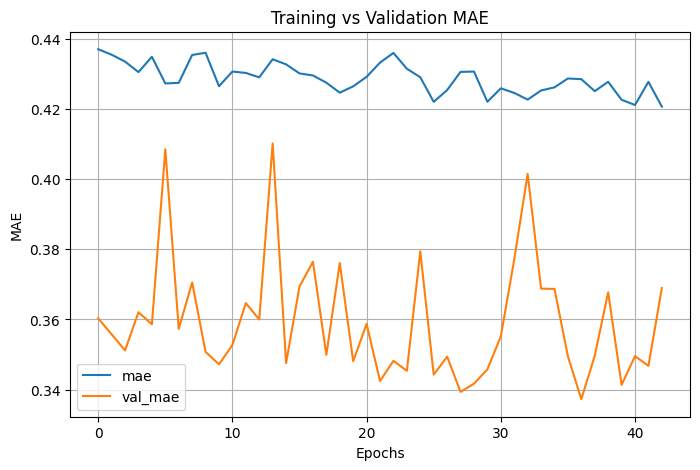

In [33]:
# Let's plot a table that shows jow the different values affect performance:
history = best_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=50,
    callbacks=callbacks)


pd.DataFrame(history.history)[['mae', 'val_mae']].plot(figsize=(8, 5))
plt.title("Training vs Validation MAE")
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.show()


In [35]:
# Okay we will try to build a baseline dummy mean, then compare the results to that of my model

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_scaled, y_train)
y_dummy_pred = dummy.predict(X_test_scaled)

baseline_rmse = np.sqrt(mean_squared_error(y_test, y_dummy_pred))
print(f"Baaseline RMSE: {baseline_rmse:.4f}")

Baaseline RMSE: 1.1505


In [37]:
# Now let use test to find out the RMSE of the model and see how far from the baseline it is

y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE:{mae: .4f}")
print(f"MSE:{mse: .4f}")
print(f"RMSE:{rmse: .4f}")
print(f"R2 Score:{r2: .4f}")

162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE: 0.3469
MSE: 0.2721
RMSE: 0.5216
R2 Score: 0.7944


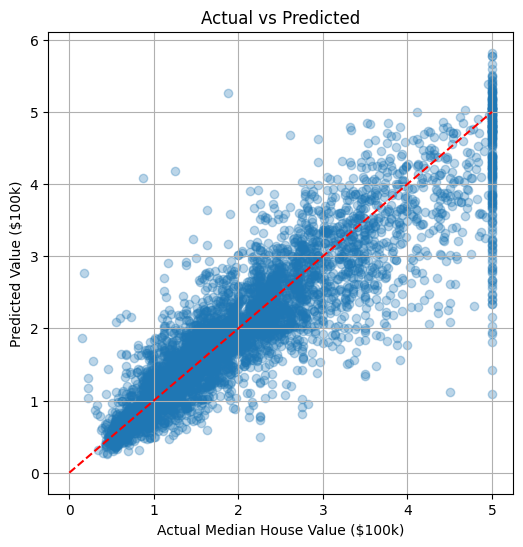

In [40]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, 5], [0, 5], "r--")
plt.xlabel("Actual Median House Value ($100k)")
plt.ylabel("Predicted Value ($100k)")
plt.title("Actual vs Predicted")
plt.grid(True)

plt.show()

In [1]:
# At the end, my Deep Learning model achieves a RMSE of $52k, 
# and explains 79% of the variation in the California median house values. The average error
# (MAE) is about $34k. 

In [19]:
# rememeber our random forest that gave us the best result of $43k. Let us look at the metrics
# from it as well 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = rndfrst_bestmodel.predict(X_test_df)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE:{mae: .4f}")
print(f"MSE:{mse: .4f}")
print(f"RMSE:{rmse: .4f}")
print(f"R2 Score:{r2: .4f}")

MAE: 0.2793
MSE: 0.1892
RMSE: 0.4350
R2 Score: 0.8570


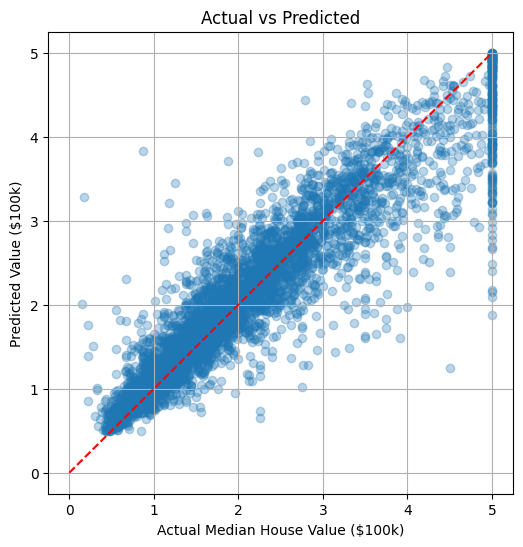

In [20]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, 5], [0, 5], "r--")
plt.xlabel("Actual Median House Value ($100k)")
plt.ylabel("Predicted Value ($100k)")
plt.title("Actual vs Predicted")
plt.grid(True)

plt.show()

In [ ]:
# Now we have found out that the Random forest after clustering gave the best result with 
# RMSE of $43k, explains 86% of t